# Dataset Preparation   

> datset preparation

In [1]:
#| default_exp data_prep

In [2]:
#| hide
%load_ext autoreload  
%autoreload 2

In [3]:
#| export
from pathlib import Path
from typing import Union, List, Dict, Any, Optional, Callable, Type, Tuple
from fastcore.all import * 
from fastcore.test import *
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import matplotlib as mpl


In [4]:
#| export
DPI =mpl.rcParams['figure.dpi']
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
#| export
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from torch.optim import AdamW
import monai

In [52]:
#| export
from transformers import SamProcessor
# we will start with base
processor = SamProcessor.from_pretrained('facebook/sam-vit-base')

In [7]:
im_path = Path(Path.cwd().parent/'data/patch_images')
msk_path = Path(Path.cwd().parent/'data/patch_masks')

In [8]:
#| export
def get_dataset(
        im_path:Union[Path,str],
        msk_path:Union[Path, str]
        ):
    "Create a dataset from image and mask path"

    # in case of it is string
    if isinstance(im_path, str):
        im_path = Path(im_path)
        msk_path = Path(msk_path)

    images = [Image.fromarray(cv2.imread(i.as_posix(),-1)) for i in im_path.ls(file_exts='.png')]
    print(f' image has {len(images)} images')
    masks = []
    for i in msk_path.ls(file_exts='.png'):
        msk = cv2.imread(i.as_posix(), -1)
        if msk.max() >1:
            if msk.shape[0]!= 256:
                print(msk.shape)
            msk_=Image.fromarray(msk)
            masks.append(msk_)

    print(f' masks has {len(masks)} images')
    dataset_dict = {
        'image':images,
        'label':masks
    }
    dataset = Dataset.from_dict(dataset_dict)
    return dataset

    

# Dataset from own computer

In [36]:
dataset = get_dataset(
    im_path,
    msk_path

)
dataset

 image has 1642 images
 masks has 1642 images


Dataset({
    features: ['image', 'label'],
    num_rows: 1642
})

In [10]:
test_eq(len(dataset['image']), len(dataset['label']))

In [35]:
#| export
def show_dataset(dataset):
    idx = np.random.randint(0, len(dataset))
    print(f' dataset index will be visualized: {idx}')
    im_ = dataset[idx]['image']
    msk_ = dataset[idx]['label']
    fig, ax = plt.subplots(
        1, 2, figsize=(10, 5)
    )
    ax[0].imshow(im_)
    ax[1].imshow(msk_)


 dataset index will be visualized: 224


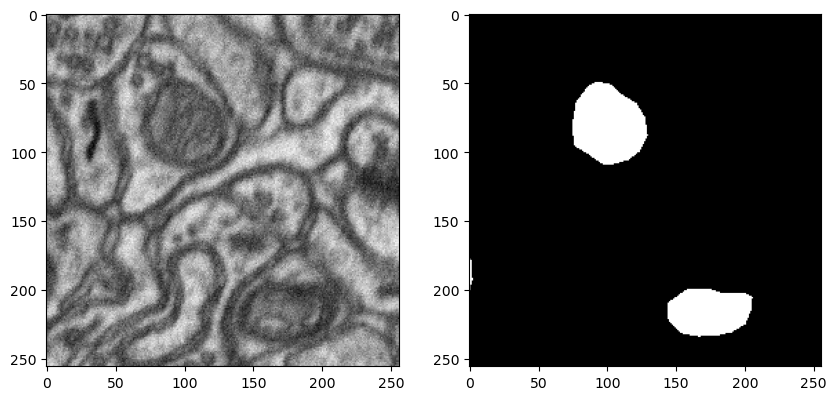

In [39]:
show_dataset(dataset)

# In case of download data from huggingface

In [40]:
from datasets import load_dataset

dataset = load_dataset("hasangoni/Electron_microscopy_dataset")

Found cached dataset parquet (/home/hasan/.cache/huggingface/datasets/hasangoni___parquet/hasangoni--Electron_microscopy_dataset-f1bcfa6489f74966/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1642
    })
})

In [50]:
def show_hf_dataset(
        dataset:Dataset,
        idx:Union[int, None]=None,
        split:str='train'
        ):
    "Show hugging face random index"

    if idx is None:
        idx = np.random.randint(0, len(dataset[split]))

    print(f' dataset index will be visualized: {idx}')
    im_ = dataset[split]['image'][idx]
    msk_ = dataset[split]['label'][idx]
    fig, ax = plt.subplots(
        1, 2, figsize=(10, 5)
    )
    ax[0].imshow(im_)
    ax[1].imshow(msk_)
    


 dataset index will be visualized: 189


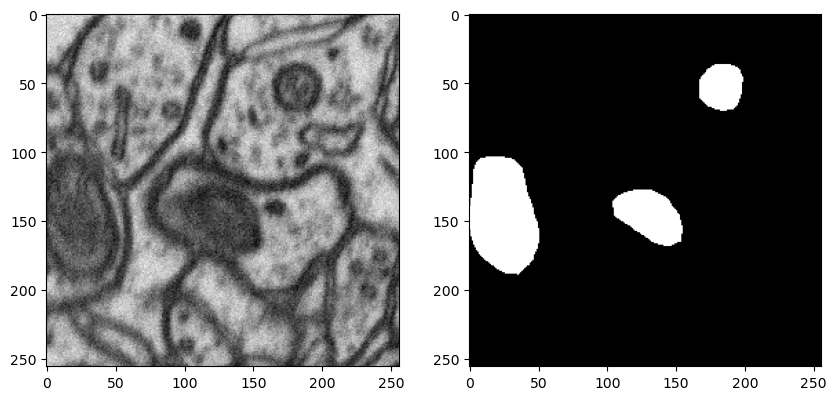

In [54]:
show_hf_dataset(dataset)

In [40]:
#| export
def get_bounding_box(
        ground_truth_map
        ):

    print(ground_truth_map.shape, type(ground_truth_map))

    y_, x_ = np.where(ground_truth_map> 0)
    x_min, x_max = np.min(x_), np.max(x_)
    y_min, y_max = np.min(y_), np.max(y_)

    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

- Careful here to make difference between torch Dataset and datsets.Dataset

In [41]:
#| export
from torch.utils.data import Dataset


In [42]:
#| export
class SAMDataset(Dataset):
    "Creating dataset for SAM training"

    def __init__(
            self,
            dataset,
            processors
            ):
        self.dataset = dataset
        self.processors = processors

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        mask = np.array(item['label'])
        prompt = get_bounding_box(mask)

        # prepare image and prompt for model
        inputs = self.processors(
                                 image, 
                                 input_boxes=[[prompt]],
                                 return_tensors="pt"
                                 )
        # remove batch dimension created by the processor
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs['ground_truth_mask'] = mask
        return inputs

In [43]:
train_ds = SAMDataset(
    dataset=dataset, 
    processors=processor)

In [45]:
example = train_ds[0]
for k,v in example.items():
    print(f'{k}: {v.shape}')

(256, 256) <class 'numpy.ndarray'>
pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [46]:
train_dl = DataLoader(
    train_ds, 
    batch_size=2, 
    shuffle=True
  )

In [47]:

batch = next(iter(train_dl))
for k,v in batch.items():
    print(k,v.shape)


(256, 256) <class 'numpy.ndarray'>
(256, 256) <class 'numpy.ndarray'>
pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [53]:
#| hide
import nbdev; nbdev.nbdev_export()